## Distribution Shift (CIFAR 10) 

In [23]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
import os 

import warnings
warnings.filterwarnings("ignore")

In [24]:
device_name = 'cuda:1' 

device = torch.device(device_name if torch.cuda.is_available() else "cpu")

In [25]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode().splitlines()
print(imagenet_classes[0])

tench


In [26]:
### import archetecture of models 

from trained_models_cifar10.models.vgg_models import * 
from trained_models_cifar10.models.resnet_models import * 
from trained_models_cifar10.models.densenet_models import * 
from trained_models_cifar10.models.mobilenetv2_cifar10 import * 
from trained_models_cifar10.models.googlenet_cifar10 import * 
from trained_models_cifar10.models.xception_cifar10 import * 
from trained_models_cifar10.models.inceptionv3_cifar10 import * 

In [27]:
## getting the archetecture of model from models.vgg_models 
vgg19_model = VGG('VGG19')
resnet50_model = ResNet50() 
densenet169_model = DenseNet169() 
mobilenetV2_model = MobileNetV2() 
googlenet_model = GoogLeNet()  
xception_model = xception()  
inceptionv3_model = inceptionv3()

In [28]:
trained_models_directory = "trained_models_cifar10/" 

vgg_19_model_file_name = "vgg19_cifar10_lr01.pth" 
resnet50_model_file_name = "resnet50_cifar10_lr01.pth" 
densenet169_model_file_name = "densenet169_cifar10_lr01.pth" 
mobilenetV2_model_file_name = "mobilenetv2_cifar10_lr01.pth" 
googlenet_model_file_name = "googlenet_cifar_lr01.pth" 
xception_model_file_name = "xception_cifar10_lr01.pth" 
inceptionv3_model_file_name = "inceptionv3_cifar10_lr01.pth"

vgg19_path = os.path.join(trained_models_directory, vgg_19_model_file_name) 
resnet50_path = os.path.join(trained_models_directory, resnet50_model_file_name) 
densenet169_path = os.path.join(trained_models_directory, densenet169_model_file_name) 
mobilenetV2_path = os.path.join(trained_models_directory, mobilenetV2_model_file_name) 
googlenet_path = os.path.join(trained_models_directory, googlenet_model_file_name) 
xception_path = os.path.join(trained_models_directory, xception_model_file_name) 
inceptionv3_path = os.path.join(trained_models_directory, inceptionv3_model_file_name) 

## load the model 
vgg19_model.load_state_dict(torch.load(vgg19_path, map_location=device_name)['net'])
resnet50_model.load_state_dict(torch.load(resnet50_path, map_location=device_name)['net'])
densenet169_model.load_state_dict(torch.load(densenet169_path, map_location=device_name)['net'])
mobilenetV2_model.load_state_dict(torch.load(mobilenetV2_path, map_location=device_name)['net'])
googlenet_model.load_state_dict(torch.load(googlenet_path, map_location=device_name)['net'])
xception_model.load_state_dict(torch.load(xception_path, map_location=device_name)['net'])
inceptionv3_model.load_state_dict(torch.load(inceptionv3_path, map_location=device_name)['net'])

<All keys matched successfully>

In [7]:
trained_pool = [
                # vgg19_model.eval(), 
                resnet50_model.eval(), 
                densenet169_model.eval(), 
                mobilenetV2_model.eval(), 
                googlenet_model.eval(), 
                xception_model.eval(), 
                inceptionv3_model.eval()
               ]


model_names = [
    # "VGG19",
    "ResNet50",
    "DenseNet169",
    "MobileNetV2",
    "GoogleNet", 
    "Xception", 
    "InceptionV3"
]

### Dataset Loading 

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the full CIFAR10 test set (10,000 samples)
full_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

# Calculate split sizes
val_size = int(0.80 * len(full_testset))  # 7000
test_size = len(full_testset) - val_size  # 3000

# Randomly split into validation and test subsets
val_set, test_set = random_split(
    full_testset, [val_size, test_size],
    generator=torch.Generator().manual_seed(56)
)

# Create DataLoaders
valloader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Validation samples: 8000
Test samples: 2000


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

# Define transforms (same as CIFAR-10 for consistency)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

class CIFAR10_1(Dataset):
    def __init__(self, data_path, labels_path, transform=None):
        self.data = np.load(data_path)  # shape (2000, 32, 32, 3)
        self.labels = np.load(labels_path)  # shape (2000,)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

# Load CIFAR-10.1 dataset
cifar10_1 = CIFAR10_1(
    data_path='./cifar10.1_v6_data.npy',
    labels_path='./cifar10.1_v6_labels.npy',
    transform=transform
)

# DataLoader
cifar10_1_loader = DataLoader(cifar10_1, batch_size=100,
                              shuffle=False, num_workers=2)

print(f"CIFAR-10.1 samples: {len(cifar10_1)}")


CIFAR-10.1 samples: 2000


## Base Models 

In [10]:
def visualize_test_and_roc(test_img, roc_imgs, local_labels, class_names=None):
    def denormalize(img_tensor, mean, std):
        mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
        std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
        return img_tensor * std + mean

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225] 

    k = roc_imgs.size(0)
    ncols = min(k, 5)
    nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    
    # Plot test image
    plt.subplot(nrows, ncols, 1)
    denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
    img_np = TF.to_pil_image(denorm_img.cpu())
    plt.imshow(img_np)
    plt.title("Test Image")
    plt.axis("off")
    
    # Plot RoC images
    for i in range(k):
        plt.subplot(nrows, ncols, i + 2)
        denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        label = local_labels[i]
        if class_names:
            label = class_names[label]
        plt.imshow(img_np)
        plt.title(f"RoC #{i+1}\nLabel: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [11]:
def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']

In [12]:
def fire_check(local_labels, preds, per_class_min=1):
    local_labels = np.asarray(local_labels)

    # If preds are logits/probs, convert to labels
    preds = np.asarray(preds)
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)

    # Classes present in the RoC (unique, not repeated)
    classes_in_roc = np.unique(local_labels)

    # Check: for each class c in RoC, there is at least `per_class_min` correct prediction
    missing = []
    for c in classes_in_roc:
        mask = (local_labels == c)
        n_correct = int(np.sum(preds[mask] == c))
        if n_correct < per_class_min:
            missing.append((int(c), n_correct))  # track which class is short

    fire_ok = (len(missing) == 0)
    return fire_ok

## VisionDES 

In [100]:

class VisionDES: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch8_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        images = F.interpolate(images, size=(224, 224), mode="bilinear", align_corners=False) 
        return self.dino_model.forward_features(images)


    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    
    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False, top=False, n=3, use_fire=False, per_class_min=1, 
                                use_sim=False, sim_threshold=0, alpha=0.6, knorae=False):
        # Step 1: Get DINO CLS embedding for the test image
        img_for_dino = test_img.unsqueeze(0).to(device)
        img_for_dino = F.interpolate(img_for_dino, size=(224, 224), mode="bilinear", align_corners=False) 
        
        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Find k nearest neighbors in FAISS (Region of Competence)
        distances, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers — compute competence and feature similarity
        competences, soft_outputs, feature_similarities, passed_fire, correct_counts = [], [], [], [], []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)
                correct_counts.append(correct)

                # 🔥 FIRE check: at least one correct per class
                fire_ok = fire_check(local_labels, preds, per_class_min=per_class_min) 
                passed_fire.append(fire_ok)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())

        # 5️⃣ KNORA-E selection logic
        if knorae: 
            selected_indices = []
            required_correct = k  # start with strict condition (all correct)
            while required_correct >= 1 and not selected_indices:
                selected_indices = [i for i, c in enumerate(correct_counts) if c >= required_correct]
                required_correct -= 1
    
            if not selected_indices:  # failsafe: fall back to all models
                selected_indices = list(range(len(self.pool)))

            for i in range(len(self.pool)): 
                if i not in selected_indices: 
                    competences[i] = 0.0 
                    # feature_similarities[i] = 0.0 
    
        # Step 5: Combine competence & feature similarity into a score
        if use_sim:
            selected_feature_sims = [s if s > sim_threshold else 0.0 for s in feature_similarities]
            combined_scores = [alpha * c + (1 - alpha) * s for c, s in zip(competences, selected_feature_sims)]
        else:
            combined_scores = competences[:]
        
        if use_fire:
            combined_scores = [s if passed_fire[i] else 0.0 for i, s in enumerate(combined_scores)]
        
        # Step 6: Select models
        if top:
            top_n_idx = np.argsort(combined_scores)[::-1][:n]  # top-n in descending order
            total_score = sum(combined_scores[i] for i in top_n_idx)
            if total_score == 0:
                weights = [1.0 / n] * n
            else:
                weights = [combined_scores[i] / total_score for i in top_n_idx]
        else:
            total_score = sum(combined_scores)
            if total_score == 0:
                weights = [1.0 / len(self.pool)] * len(self.pool)
            else:
                weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation of top-n classifier outputs
        num_classes = 10
        weighted_logits = torch.zeros(10).to(device)

        if top: 
            for idx, weight in zip(top_n_idx, weights):
                # print(idx, weight, soft_outputs[idx][:10])
                weighted_logits += weight * soft_outputs[idx]
        else: 
            for prob, weight in zip(soft_outputs, weights):
                weighted_logits += weight * prob
            
    
        # Step 8: Keep track of suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
        
            if top:  # only report top-n models
                for idx, weight in zip(top_n_idx, weights):
                    prob = soft_outputs[idx]
                    comp = competences[idx]
                    sim = feature_similarities[idx]
                    fire = passed_fire[idx]
                    com_score = combined_scores[idx]
        
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
            else:  # report all models
                for idx, (comp, sim, weight, prob, fire, com_score) in enumerate(
                    zip(competences, feature_similarities, weights, soft_outputs, passed_fire, combined_scores)
                ):
                    pred_class = prob.argmax().item()
                    conf = prob[pred_class].item()
                    topk = torch.topk(prob, k=5)
        
                    print(f"Model #{idx}: {self.pool[idx].__class__.__name__}")
                    print(f"  - Competence: {comp:.4f}")
                    print(f"  - Feature similarity: {sim:.4f}")
                    print(f"  - Combined score: {com_score:.4f}")
                    print(f"  - Combined weight: {weight:.4f}")
                    print(f"  - 🔥 FIRE: {fire}")
                    print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                    print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                    print("-" * 50)
        
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
        
            print("\nModel weight distribution:")
            if top:
                for idx, w in zip(top_n_idx, weights):
                    print(f"  Model #{idx}: {w:.4f}")
            else:
                for idx, w in enumerate(weights):
                    print(f"  Model #{idx}: {w:.4f}")
        
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
        
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            print(distances)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()

    def predict(self, dataloader): 
        total = 0
        correct = 0 

        dataset_offset = 0 


### Evaluate DES 

In [101]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_des_with_fails(des_model, dataloader, dataset, average="weighted"):
    total = 0
    correct = 0
    failed_indices = []
    dataset_offset = 0  # to map dataloader batches back to dataset indices
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing VisionDES"):
            imgs, labels = imgs.to(device), labels.to(device)

            preds = []
            for idx_in_batch, img in enumerate(imgs):
                pred = des_model.predict_weighted_robust(
                    img, k=5, return_logits=False, explain=False, top=False, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0, 
                    alpha=0.6, knorae=True
                )
                preds.append(pred)

                # Collect failures (map batch index to dataset index)
                if pred != labels[idx_in_batch].item():
                    failed_indices.append(dataset_offset + idx_in_batch)

            preds = torch.tensor(preds).to(device)

            # accumulate results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            dataset_offset += labels.size(0)

    acc = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=average, zero_division=0
    )
    
    print(f"✅ Accuracy: {acc*100:.2f} | Precision: {precision*100:.2f} | Recall: {recall*100:.2f} | F1: {f1*100:.2f}")
    
    return failed_indices


In [102]:
des_model = VisionDES(val_set, trained_pool)
des_model.fit()

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████| 250/250 [01:36<00:00,  2.60it/s]


## Static Ensemble 

In [16]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [17]:
import torch
import numpy as np
from collections import Counter

class HardVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images):
        all_preds = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())

        # shape: [n_models, batch_size] → transpose to [batch_size, n_models]
        all_preds = np.stack(all_preds, axis=0).T  

        # majority vote for each sample
        final_preds = []
        for preds in all_preds:
            most_common = Counter(preds).most_common(1)[0][0]
            final_preds.append(most_common)

        return np.array(final_preds)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        votes = []
        with torch.no_grad():
            for model in self.models:
                logits = model(image.to(self.device))
                pred = torch.argmax(logits, dim=1).item()
                votes.append(pred)

        # majority voting
        final_pred = Counter(votes).most_common(1)[0][0]
        return votes, final_pred


In [32]:
from torch.utils.data import TensorDataset, DataLoader
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from collections import defaultdict


def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels[0].item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img, k=10, return_logits=True, explain=False, top=True, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=False
                )
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 
    # print(y_prob)

    return metrics



def evaluate_classifiers(pool, test_dataset, n_classes):
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    results = []

    for i, model in enumerate(pool):
        model = model.to(device)
        model.eval()
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
        f1 = f1_score(y_true, y_pred, average='macro') * 100
        try:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
        except ValueError:
            auc = float('nan')  # Handle single-class test sets

        print(f"{model.__class__.__name__}: {acc}")

        results.append({
            'classifier': model.__class__.__name__,
            'accuracy': acc,
            'f1': f1,
            'auc': auc,
        })

    return results

In [ ]:
soft_ensemble = SoftVotingEnsemble(trained_pool, device)
hard_ensemble = HardVotingEnsemble(trained_pool, device)

### Evaluation 

In [31]:
_ = evaluate_classifiers(trained_pool, cifar10_1, 10)

VGG: 84.35000000000001
ResNet: 87.64999999999999
DenseNet: 88.44999999999999
MobileNetV2: 86.7
GoogLeNet: 88.2
Xception: 85.55
InceptionV3: 88.2


In [52]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels[0].item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img, k=10, return_logits=True, explain=False, top=True, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=False
                )
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 
    # print(y_prob)

    return metrics

In [53]:
cifar10_1_loader = DataLoader(cifar10_1, batch_size=1, shuffle=False, num_workers=2)

In [55]:
predict_for_ensembles(soft_ensemble, cifar10_1_loader, "soft")
predict_for_ensembles(hard_ensemble, cifar10_1_loader, "soft")

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:34<00:00, 21.23it/s]


soft Accuracy: 89.60%  | F1: 89.58%  | AUC: 99.36%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:33<00:00, 21.29it/s]

soft Accuracy: 89.80%  | F1: 89.78%  | AUC: nan%


{'accuracy': [89.8], 'f1': [89.78039781169392], 'auc': [nan]}

In [56]:
predict_for_ensembles(des_model, cifar10_1_loader, "des+")

100%|███████████████████████████████████████████████████████████████| 2000/2000 [06:47<00:00,  4.91it/s]


des+ Accuracy: 90.15%  | F1: 90.14%  | AUC: 98.90%


{'accuracy': [90.14999999999999],
 'f1': [90.14168073813866],
 'auc': [np.float64(98.90163888888888)]}

In [221]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels[0].item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(
                    img, k=7, return_logits=True, explain=False, top=True, n=2, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.6, knorae=True
                )
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 
    # print(y_prob)

    return metrics

In [19]:
trained_pool = [
                vgg19_model.eval(), 
                resnet50_model.eval(), 
                densenet169_model.eval(), 
                mobilenetV2_model.eval(), 
                googlenet_model.eval(), 
                xception_model.eval(), 
                inceptionv3_model.eval()
               ]

In [223]:
des_model.pool = trained_pool
soft_ensemble = SoftVotingEnsemble(trained_pool, device)
hard_ensemble = HardVotingEnsemble(trained_pool, device) 

In [224]:
predict_for_ensembles(des_model, cifar10_1_loader, "des+")

100%|███████████████████████████████████████████████████████████████| 2000/2000 [07:06<00:00,  4.68it/s]

des+ Accuracy: 90.75%  | F1: 90.75%  | AUC: 98.89%


{'accuracy': [90.75],
 'f1': [90.74533524885074],
 'auc': [np.float64(98.89191666666667)]}

In [196]:
predict_for_ensembles(soft_ensemble, cifar10_1_loader, "soft")
predict_for_ensembles(hard_ensemble, cifar10_1_loader, "soft")

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.18it/s]


soft Accuracy: 89.40%  | F1: 89.38%  | AUC: 99.35%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.18it/s]

soft Accuracy: 89.30%  | F1: 89.28%  | AUC: nan%


{'accuracy': [89.3], 'f1': [89.28480938399694], 'auc': [nan]}

True y: 7

Explainability Report:
Model #0: ResNet
  - Competence: 1.0000
  - Feature similarity: 0.9658
  - Combined score: 0.9829
  - Combined weight: 0.1679
  - 🔥 FIRE: True
  - Predicted class: 7 with confidence 1.0000
  - Top-5: [7, 5, 3, 1, 9] → [1.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #1: DenseNet
  - Competence: 1.0000
  - Feature similarity: 0.9544
  - Combined score: 0.9772
  - Combined weight: 0.1669
  - 🔥 FIRE: True
  - Predicted class: 7 with confidence 0.9990
  - Top-5: [7, 9, 4, 3, 5] → [0.999, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #2: MobileNetV2
  - Competence: 1.0000
  - Feature similarity: 0.8755
  - Combined score: 0.9377
  - Combined weight: 0.1602
  - 🔥 FIRE: True
  - Predicted class: 7 with confidence 0.9490
  - Top-5: [7, 3, 9, 5, 4] → [0.949, 0.04, 0.004, 0.002, 0.002]
--------------------------------------------------
Model #3: GoogLeNet
  - Competence: 1.0000
  - Feature similari

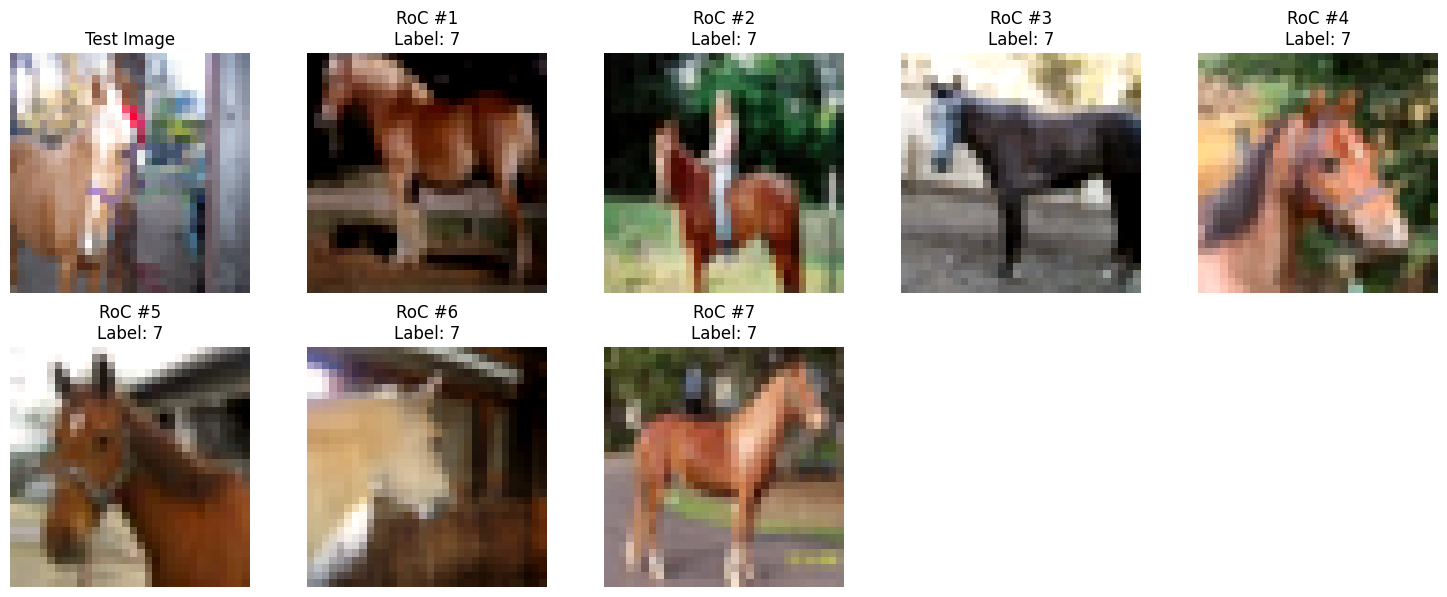

[[3263.6157 3294.4985 3299.982  3351.7227 3354.     3359.8223 3377.0732]]


7

In [103]:
index = 1452
print(f"True y: {cifar10_1[index][1]}")

des_model.predict_weighted_robust(
                    cifar10_1[index][0], k=7, return_logits=False, explain=True, top=False, n=1, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0.4, 
                    alpha=0.5, knorae=True
                )

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet

# Suppose errors[i] is a boolean array of length N (N = len(CIFAR-10.1)) 
# True = model i misclassified that sample.
errors = []

for model in trained_pool:
    wrong = []
    for imgs, labels in cifar10_1_loader:
        outputs = model(imgs.to(device))
        preds = outputs.argmax(1).cpu()
        wrong.extend((preds != labels).numpy())
    errors.append(wrong)

# Build dataframe for UpSet plot
df = pd.DataFrame({f"Model{i}": errs for i, errs in enumerate(errors)})
UpSet(df, subset_size='count', show_counts=True).plot()
plt.show()

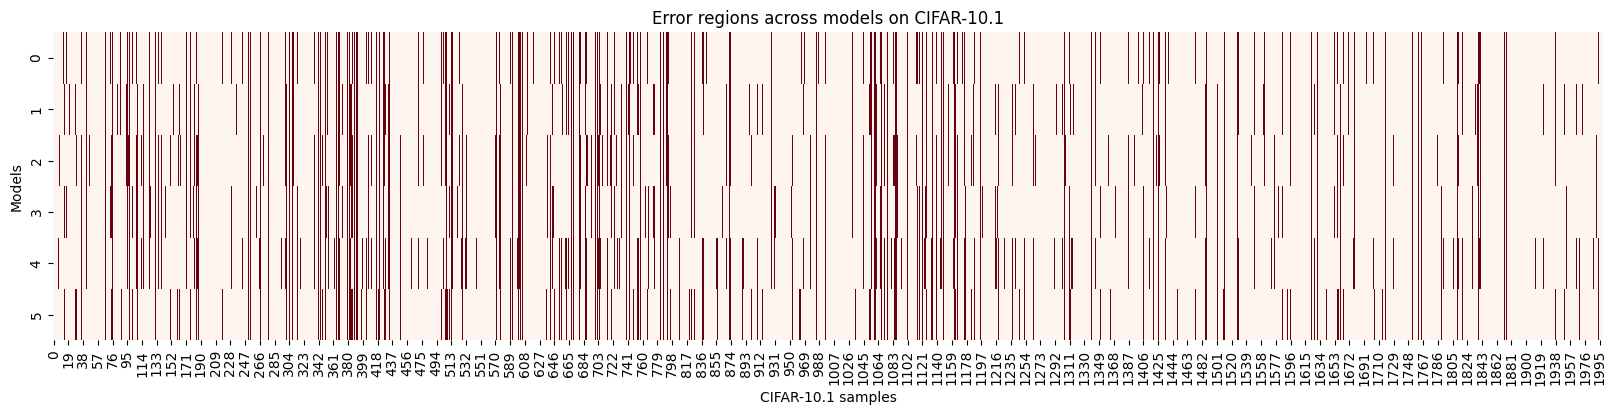

In [67]:
import seaborn as sns
import numpy as np

error_matrix = np.array(errors)  # shape (6, N)

plt.figure(figsize=(20, 4))
sns.heatmap(error_matrix, cmap="Reds", cbar=False)
plt.xlabel("CIFAR-10.1 samples")
plt.ylabel("Models")
plt.title("Error regions across models on CIFAR-10.1")
plt.show()

In [68]:
df

,Model0,Model1,Model2,Model3,Model4,Model5
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
1995,False,False,False,False,False,False
1996,False,False,False,False,False,False
1997,False,False,False,False,False,False
1998,False,False,False,False,False,False


In [ ]:
df 

In [69]:
import numpy as np

# errors: list of length 6, each element is array of shape (N,)
# N = number of CIFAR-10.1 samples (2000 in v6)
errors = np.array(errors)  # shape (6, N)

# Find samples wrong by all models
all_wrong = np.all(errors, axis=0)   # shape (N,)
num_all_wrong = np.sum(all_wrong)

print(f"Samples misclassified by all 6 models: {num_all_wrong}")

Samples misclassified by all 6 models: 90


In [70]:
90/2000 

0.045

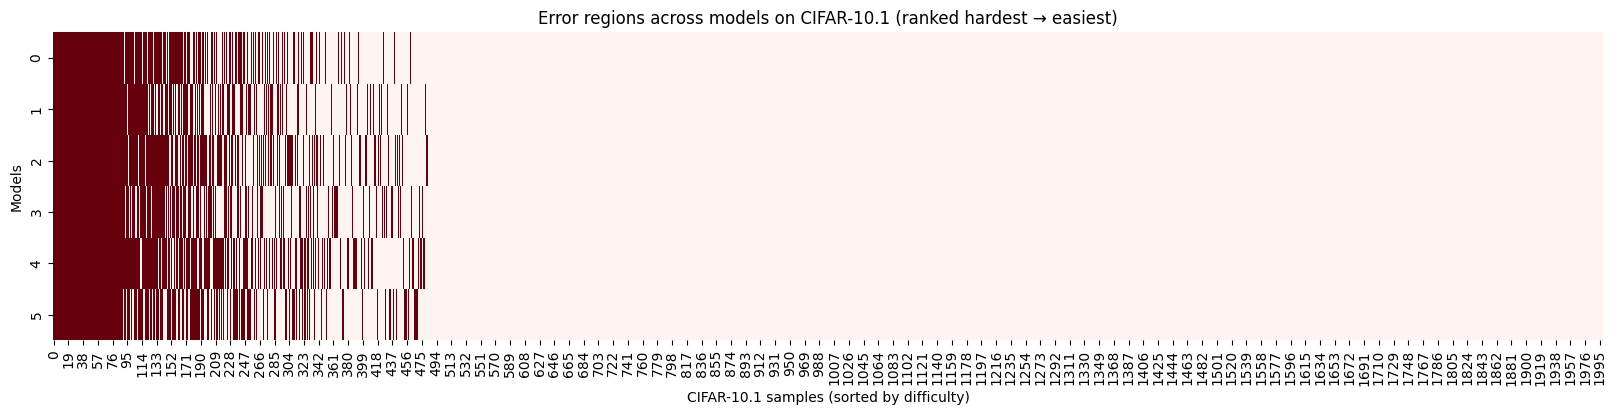

In [120]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

error_matrix = np.array(errors)  # shape (6, N)

# Count how many models failed on each sample
sample_difficulty = error_matrix.sum(axis=0)  

# Sort columns by number of errors (descending: hardest first)
sorted_indices = np.argsort(-sample_difficulty)
sorted_error_matrix = error_matrix[:, sorted_indices]

plt.figure(figsize=(20, 4))
sns.heatmap(sorted_error_matrix, cmap="Reds", cbar=False)
plt.xlabel("CIFAR-10.1 samples (sorted by difficulty)")
plt.ylabel("Models")
plt.title("Error regions across models on CIFAR-10.1 (ranked hardest → easiest)")
plt.show()

### Plot 

CIFAR-10.1: (2000, 32768)  Test dataset: (2000, 32768)


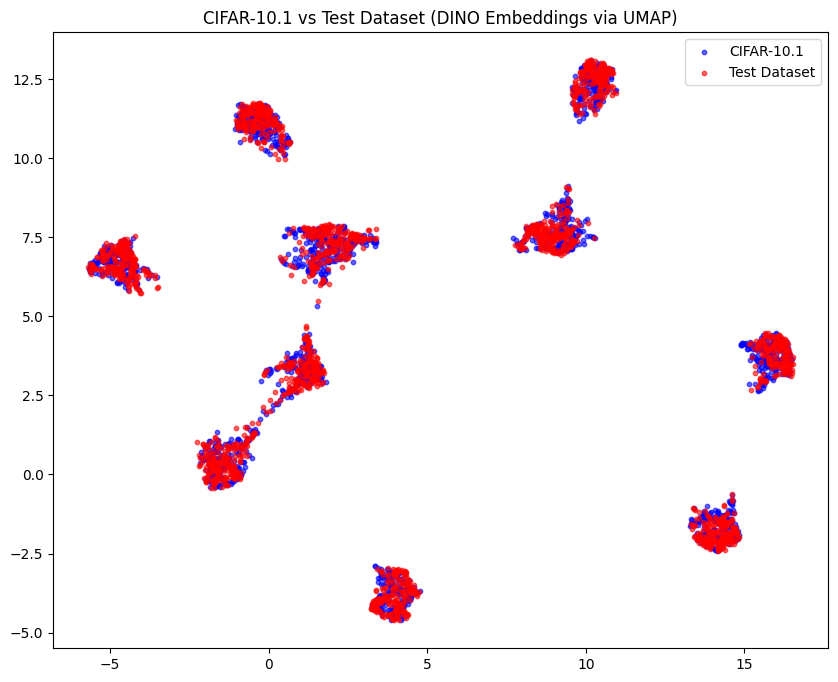

In [18]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import umap
import numpy as np

device = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------------------------------------
# 1. Load datasets
# ---------------------------------------------------------
cifar10_1_loader = DataLoader(cifar10_1, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# ---------------------------------------------------------
# 2. Load DINO model
# ---------------------------------------------------------
dino_model = timm.create_model("vit_base_patch8_224.dino", pretrained=True).to(device)
dino_model.eval()

# ---------------------------------------------------------
# 3. Embedding function
# ---------------------------------------------------------
def dino_embedder(images):
    if images.shape[1] == 1:  # grayscale → RGB
        images = images.repeat(1, 3, 1, 1)
    images = F.interpolate(images, size=(224, 224), mode="bilinear", align_corners=False)
    with torch.no_grad():
        feats = dino_model.forward_features(images)
    if isinstance(feats, dict):
        if "x_norm_clstoken" in feats:
            feats = feats["x_norm_clstoken"]
        elif "avgpool" in feats:
            feats = feats["avgpool"]
        else:
            feats = feats[list(feats.keys())[0]]
    if feats.ndim == 3:  # [B, N, D]
        feats = feats.mean(dim=1)  # average patches
    return feats.view(feats.size(0), -1)  # [B, D]

# ---------------------------------------------------------
# 4. Extract embeddings for both datasets
# ---------------------------------------------------------
def extract_embeddings(dataloader):
    embs, labels = [], []
    for images, y in dataloader:
        images = images.to(device)
        feats = resnet_embedder(images)
        embs.append(feats.cpu())
        labels.append(y)
    return torch.cat(embs).numpy(), torch.cat(labels).numpy()

emb_cifar10_1, labels_cifar10_1 = extract_embeddings(cifar10_1_loader)
emb_test, labels_test = extract_embeddings(test_loader)

print("CIFAR-10.1:", emb_cifar10_1.shape, " Test dataset:", emb_test.shape)

# ---------------------------------------------------------
# 5. Combine datasets
# ---------------------------------------------------------
all_embeddings = np.vstack([emb_cifar10_1, emb_test])
dataset_ids = np.array([0]*len(emb_cifar10_1) + [1]*len(emb_test))  # 0=CIFAR-10.1, 1=Test

# ---------------------------------------------------------
# 6. UMAP dimensionality reduction
# ---------------------------------------------------------
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
embeddings_2d = umap_reducer.fit_transform(all_embeddings)

# ---------------------------------------------------------
# 7. Plot comparison
# ---------------------------------------------------------
plt.figure(figsize=(10, 8))

# Plot CIFAR-10.1
plt.scatter(
    embeddings_2d[dataset_ids == 0, 0],
    embeddings_2d[dataset_ids == 0, 1],
    c="blue", s=10, alpha=0.6, label="CIFAR-10.1"
)

# Plot Test dataset
plt.scatter(
    embeddings_2d[dataset_ids == 1, 0],
    embeddings_2d[dataset_ids == 1, 1],
    c="red", s=10, alpha=0.6, label="Test Dataset"
)

plt.legend()
plt.title("CIFAR-10.1 vs Test Dataset (DINO Embeddings via UMAP)")
plt.show()
